## Converting to elo scores

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
from BT_criteria import VectorBTD
import matplotlib.patheffects as patheffects
from sklearn.decomposition import PCA
from eigentrust import eigentrust

/Users/jchang153/miniforge3/envs/tf-metal/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_vector_btd(path, num_criteria, num_models, d, device='cpu'):
    model = VectorBTD(num_criteria, num_models, d).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

path = f'transcript/20250726_000000/omit claude 3.5/unit btd d5/'
d = 5
model_path = path + 'model.pt'
num_models = 5  # Updated for 20 models
num_criteria = 1
model = load_vector_btd(model_path, num_criteria, num_models, d)

In [58]:
model

VectorBTD(
  (u): Embedding(5, 5)
  (v): Embedding(5, 5)
  (log_lambda): Embedding(5, 1)
)

In [59]:
def computeE(model, t):
    E = np.zeros((5,5))

    for j in range(5):
        for k in range(5):
            if j == k:
                continue
            E[j,k] = 0
            for i in range(5):
                c,i,j,k = torch.tensor(0, dtype=torch.long), torch.tensor(i, dtype=torch.long), torch.tensor(j, dtype=torch.long), torch.tensor(k, dtype=torch.long)
                tie_prob, win_prob, _ = list(torch.softmax(torch.tensor([i for i in model.get_prob(c,i,j,k)]), dim=0).detach().numpy())
                E[j,k] += t[i] * (win_prob + 0.5 * tie_prob)
    return E

In [49]:
import numpy as np

def compute_elo_ratings(E, scale=400, center=1500, eps=1e-6):
    """
    Compute least-squares Elo ratings from a matrix of pairwise win probabilities.

    Parameters
    ----------
    E : ndarray, shape (N, N)
        Matrix of win probabilities. E[j, k] = P(j beats k), with E[j, j] = np.nan or 0.5.
    scale : float
        Elo scaling factor. Default is 400 (standard chess scale).
    center : float
        Mean Elo rating to center around. Default is 1500.
    eps : float
        Clipping parameter to avoid log(0). Should be small (e.g., 1e-6).

    Returns
    -------
    R : ndarray, shape (N,)
        Vector of Elo ratings.
    """
    N = E.shape[0]
    R = np.zeros(N)

    # Ensure matrix is well-defined
    E_clipped = np.clip(E, eps, 1 - eps)
    
    # Compute log-odds for each pair
    log_odds = np.log10(E_clipped / (1 - E_clipped))

    # Replace diagonal (self-play) with 0 or nan
    np.fill_diagonal(log_odds, 0.0)

    # Sum log-odds row-wise (excluding self)
    for j in range(N):
        R[j] = scale / N * np.sum(log_odds[j, :])  # sum over k ≠ j

    # Center ratings (e.g., average = 1500)
    # print(R, np.mean(R))
    R -= np.mean(R)
    R += center

    return R

In [79]:
t = [  0.2594,   0.1521,   0.3490,   0.1500,   0.0896]
t = [0.2416, 0.1827, 0.2851, 0.1565, 0.1341]
E = computeE(model, t)
[int(i) for i in compute_elo_ratings(E)]

/var/folders/qj/xk2kpqqd6cqb4q976yfqswf00000gn/T/ipykernel_69910/653078349.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c,i,j,k = torch.tensor(0, dtype=torch.long), torch.tensor(i, dtype=torch.long), torch.tensor(j, dtype=torch.long), torch.tensor(k, dtype=torch.long)


[1545, 1490, 1576, 1459, 1427]

In [78]:
t = [  0.2594,   0.1521,   0.3490,   0.1500,   0.0896]
t = [0.2416, 0.1827, 0.2851, 0.1565, 0.1341]
for i in t:
    print(int(1500+400/np.log(10) * np.log(5*i)))

1532
1484
1561
1457
1430


In [57]:
lo = [0.2413,0.1445,0.3364,0.1486,0.0888]
hi = [0.2600, 0.1595, 0.3582, 0.1627, 0.0961]

In [62]:
E = computeE(model, t)
[int(i) for i in compute_elo_ratings(E)]

/var/folders/qj/xk2kpqqd6cqb4q976yfqswf00000gn/T/ipykernel_69910/653078349.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c,i,j,k = torch.tensor(0, dtype=torch.long), torch.tensor(i, dtype=torch.long), torch.tensor(j, dtype=torch.long), torch.tensor(k, dtype=torch.long)


[1546, 1476, 1582, 1477, 1417]

## testing new trust matrix

In [ ]:
def load_vector_btd(path, num_criteria, num_models, d, device='cpu'):
    model = VectorBTD(num_criteria, num_models, d).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

In [67]:
def compute_trust_matrix_ties(model, device='cpu'):
    U = model.u.weight.data.to(device)  # shape (N, d)
    V = model.v.weight.data.to(device)  # shape (N, d)
    log_lambda = model.log_lambda.weight.data.to(device)  # shape (N, 1)
    
    # Compute raw scores s_ij = exp(u_i^T v_j)
    logits = U @ V.t()                  # shape (N, N)
    s = torch.exp(logits)               # shape (N, N)
    
    # Convert log_lambda to lambda
    lambda_i = torch.exp(log_lambda)    # shape (N, 1)
    
    # Compute tie terms
    # For S_ij = s_ij + (1/2) * lambda_i * sum_{k≠j} sqrt(s_ij * s_ik)
    # This can be rewritten as:
    # S_ij = s_ij + (1/2) * lambda_i * sqrt(s_ij) * (sum_k sqrt(s_ik) - sqrt(s_ij))
    
    sqrt_s = torch.sqrt(s)              # shape (N, N)
    sqrt_s_sum = sqrt_s.sum(dim=1, keepdim=True)  # shape (N, 1) - sum_k sqrt(s_ik) for each i
    
    # For each i,j: sqrt(s_ij) * (sum_k sqrt(s_ik) - sqrt(s_ij))
    tie_terms = sqrt_s * (sqrt_s_sum - sqrt_s)  # shape (N, N)
    
    # Apply lambda_i and the 1/2 factor
    tie_contribution = 0.5 * lambda_i * tie_terms  # shape (N, N)
    
    # Compute S_ij = s_ij + tie_contribution
    S = s + tie_contribution            # shape (N, N)
    
    # Normalize rows to get T_ij
    Z_i = S.sum(dim=1, keepdim=True)    # shape (N, 1)
    T = S / Z_i                         # shape (N, N)
    
    return T

In [77]:
path = f'transcript/20250726_000000/omit claude 3.5/unit btd d2/'
d = 2
model_path = path + 'model.pt'
num_models = 5  # Updated for 20 models
num_criteria = 1
model = load_vector_btd(model_path, num_criteria, num_models, d)

T = compute_trust_matrix_ties(model)
t = eigentrust(T, alpha=0)
t

Starting eigentrust iteration


  0%|          | 4/1000 [00:00<00:00, 4943.20it/s]


tensor([0.2416, 0.1827, 0.2851, 0.1565, 0.1341])

## Plotting Elo

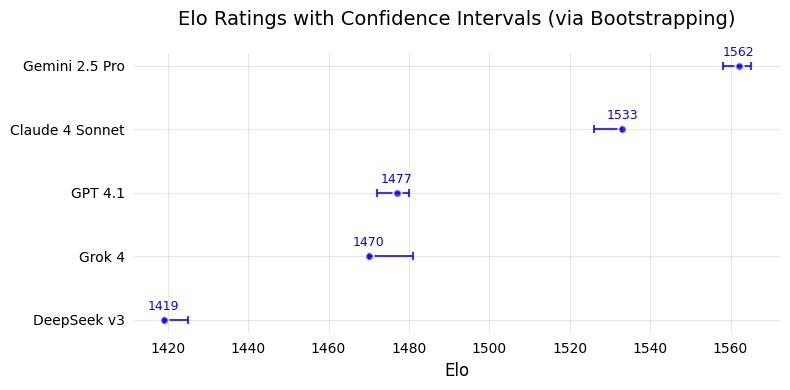

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
lowerbound = [1526.09839956, 1472.59128714, 1558.35970158, 1470.75834211, 1419.06680992]
upperbound = [1533.89202364, 1480.47115121, 1565.10709876, 1481.39088762, 1425.21253791]
true_means = [1533.25765726, 1477.59555003, 1562.61966053, 1470.94814522, 1419.87403636]

lowerbound = [int(i) for i in lowerbound]
upperbound = [int(i) for i in upperbound]
true_means = [int(i) for i in true_means]

# Create labels for each model/item
labels = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]

# Combine data and sort by true means
data = list(zip(true_means, lowerbound, upperbound, labels))
data_sorted = sorted(data, key=lambda x: x[0])

# Extract sorted data
true_means_sorted = [x[0] for x in data_sorted]
lowerbound_sorted = [x[1] for x in data_sorted]
upperbound_sorted = [x[2] for x in data_sorted]
labels_sorted = [x[3] for x in data_sorted]

# Calculate error bars (distances from mean to bounds)
# For matplotlib errorbar: xerr[0] = distance from mean to lower bound (should be positive)
#                         xerr[1] = distance from mean to upper bound (should be positive)
lower_errors = []
upper_errors = []

for i in range(len(true_means_sorted)):
    lower_err = true_means_sorted[i] - lowerbound_sorted[i]  # true_mean - lower_bound
    upper_err = upperbound_sorted[i] - true_means_sorted[i]  # upper_bound - true_mean
    
    # Ensure non-negative (just in case of data inconsistencies)
    lower_errors.append(max(0, lower_err))
    upper_errors.append(max(0, upper_err))

# Create the plot
fig, ax = plt.subplots(figsize=(8,4))

# Create y positions
y_pos = np.arange(len(true_means_sorted))

color="#0D00FF"

# Create horizontal error bars
ax.errorbar(true_means_sorted, y_pos, 
           xerr=[lower_errors, upper_errors],
           fmt='o',                    # circle markers
           color=color,           # nice blue color
        #    ecolor='#A23B72',          # pinkish error bar color
        #    elinewidth=2.5,            # thicker error bars
           capsize=3,                 # cap size for error bars
           capthick=1.5,              # cap thickness
           markersize=6,              # larger dots
        #    markerfacecolor='#F18F01', # orange fill for dots
           markeredgecolor="#FFFFFF", # blue edge for dots
           markeredgewidth=1.5,         # thicker edge
           alpha=0.8)

# Customize the plot
ax.set_yticks(y_pos)
ax.set_yticklabels(labels_sorted)
ax.set_xlabel('Elo', fontsize=12)
# ax.set_ylabel('Models', fontsize=12, fontweight='bold')
ax.set_title('Elo Ratings with Confidence Intervals (via Bootstrapping)', 
             fontsize=14, pad=20)

# Add grid for better readability
ax.grid(True, alpha=0.3)#, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Set background color
# ax.set_facecolor('#F8F9FA')
# fig.patch.set_facecolor('white')

# Improve layout
plt.tight_layout()

# Add some styling touches
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# Add value annotations on the dots
for i, (x, y) in enumerate(zip(true_means_sorted, y_pos)):
    ax.annotate(f'{x}', 
               (x, y), 
               xytext=(0, 5), 
               textcoords='offset points',
               ha='center', 
               va='bottom',
               fontsize=9,
            #    fontweight='bold',
               color=color)
# ax.grid(False)
# plt.axis('off')
ax.spines[['left', 'bottom']].set_visible(False)
ax.tick_params(axis='x', bottom=False) 
ax.tick_params(axis='y', left=False) 
plt.show()

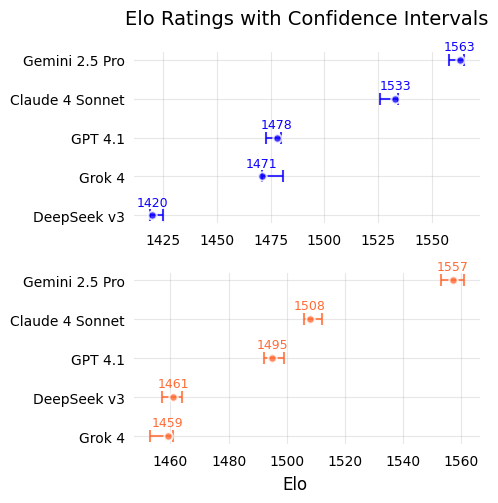

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# First dataset (top plot)
lowerbound_1 = [1526.09839956, 1472.59128714, 1558.35970158, 1470.75834211, 1419.06680992]
upperbound_1 = [1533.89202364, 1480.47115121, 1565.10709876, 1481.39088762, 1425.21253791]
true_means_1 = [1533.25765726, 1477.59555003, 1562.61966053, 1470.94814522, 1419.87403636]

lowerbound_1 = [round(i) for i in lowerbound_1]
upperbound_1 = [round(i) for i in upperbound_1]
true_means_1 = [round(i) for i in true_means_1]

labels_1 = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]

# Second dataset (bottom plot) - placeholder data, replace with your actual data
true_means_2 = [1507.89569307, 1494.52951082, 1557.39328427, 1459.49007264, 1461.45300643]
upperbound_2 = [1511.91755008, 1499.08407186, 1561.42785074, 1460.86957999, 1464.02644527]
lowerbound_2 = [1506.06096205, 1492.27854837, 1553.45196683, 1452.87735192, 1456.94607609]

lowerbound_2 = [round(i) for i in lowerbound_2]
upperbound_2 = [round(i) for i in upperbound_2]
true_means_2 = [round(i) for i in true_means_2]

labels_2 = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]

# true_means_3 = [1492.56357628, 1464.37380811, 1571.03197262, 1480.84360872, 1466.91451581]
# true_means_3 = [round(i) for i in true_means_3]
# lowerbound_3 = [i-5 for i in true_means_3] # Replace with your data
# upperbound_3 = [i+5 for i in true_means_3]  # Replace with your data

# labels_3 = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]

# true_means_4 = [1517.50205079, 1495.42358275, 1538.48583414, 1468.77858169, 1468.98637812]
# true_means_4 = [round(i) for i in true_means_4]
# lowerbound_4 = [i-5 for i in true_means_4] # Replace with your data
# upperbound_4 = [i+5 for i in true_means_4]  # Replace with your data

# labels_4 = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]


def process_data(lowerbound, upperbound, true_means, labels):
    """Process and sort data by true means"""
    # Combine data and sort by true means
    data = list(zip(true_means, lowerbound, upperbound, labels))
    data_sorted = sorted(data, key=lambda x: x[0])
    
    # Extract sorted data
    true_means_sorted = [x[0] for x in data_sorted]
    lowerbound_sorted = [x[1] for x in data_sorted]
    upperbound_sorted = [x[2] for x in data_sorted]
    labels_sorted = [x[3] for x in data_sorted]
    
    # Calculate error bars
    lower_errors = []
    upper_errors = []
    
    for i in range(len(true_means_sorted)):
        lower_err = true_means_sorted[i] - lowerbound_sorted[i]
        upper_err = upperbound_sorted[i] - true_means_sorted[i]
        
        lower_errors.append(max(0, lower_err))
        upper_errors.append(max(0, upper_err))
    
    return true_means_sorted, lower_errors, upper_errors, labels_sorted

def plot_elo_data(ax, true_means_sorted, lower_errors, upper_errors, labels_sorted, color, title):
    """Plot elo data on given axis"""
    y_pos = np.arange(len(true_means_sorted))
    
    # Create horizontal error bars
    ax.errorbar(true_means_sorted, y_pos, 
               xerr=[lower_errors, upper_errors],
               fmt='o',
               color=color,
               capsize=4,
               capthick=1.5,
               markersize=6,
               markeredgecolor="#FFFFFF",
               markeredgewidth=1.5,
               alpha=0.8)
    
    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels_sorted)
    ax.set_title(title, fontsize=14, pad=20)#, x=.385)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    ax.set_axisbelow(True)
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', bottom=False) 
    ax.tick_params(axis='y', left=False)
    
    # Add value annotations
    for i, (x, y) in enumerate(zip(true_means_sorted, y_pos)):
        ax.annotate(f'{x}', 
                   (x, y), 
                   xytext=(0, 5), 
                   textcoords='offset points',
                   ha='center', 
                   va='bottom',
                   fontsize=9,
                   color=color)

# Process both datasets
data1 = process_data(lowerbound_1, upperbound_1, true_means_1, labels_1)
data2 = process_data(lowerbound_2, upperbound_2, true_means_2, labels_2)
# data3 = process_data(lowerbound_3, upperbound_3, true_means_3, labels_3)
# data4 = process_data(lowerbound_4, upperbound_4, true_means_4, labels_4)

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))

# Plot first dataset (top)
plot_elo_data(ax1, *data1, color="#0D00FF", 
              title='Elo Ratings with Confidence Intervals')

# Plot second dataset (bottom)
plot_elo_data(ax2, *data2, color="#FF6B35", title=None)

# # Plot second dataset (bottom)
# plot_elo_data(ax3, *data3, color="#0DFF00", title=None)


# # Plot second dataset (bottom)
# plot_elo_data(ax4, *data4, color="#FB00FF", title=None)

# Add shared x-label
fig.text(0.6, 0.01, 'Elo', ha='center', fontsize=12)

# Improve layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
# plt.savefig('figure.png', dpi=500)
plt.show()

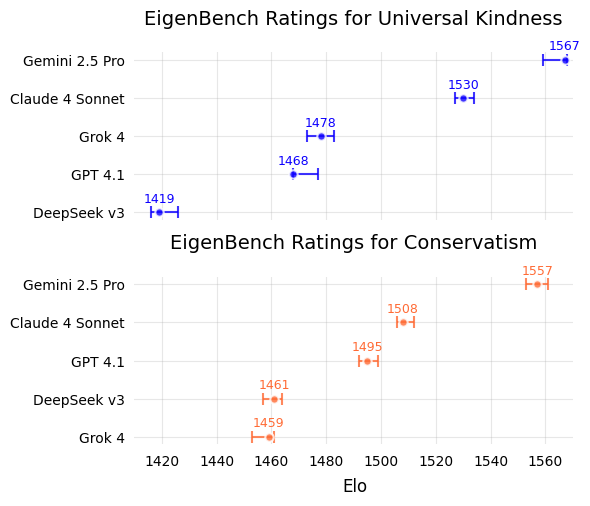

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# First dataset (top plot)
# lowerbound_1 = [1526.09839956, 1472.59128714, 1558.35970158, 1470.75834211, 1419.06680992]
# upperbound_1 = [1533.89202364, 1480.47115121, 1565.10709876, 1481.39088762, 1425.21253791]
# true_means_1 = [1533.25765726, 1477.59555003, 1562.61966053, 1470.94814522, 1419.87403636]

lowerbound_1 = [1526.50238147, 1467.53081678, 1558.89829036, 1473.17781202, 1416.41114206]
upperbound_1 = [1533.85244653, 1477.31226109, 1567.77118283, 1482.67520447, 1426.05035202]
true_means_1 = [1530.2917599 , 1468.15369687, 1566.74958034, 1477.99036336, 1419.04549206]

lowerbound_1 = [round(i) for i in lowerbound_1]
upperbound_1 = [round(i) for i in upperbound_1]
true_means_1 = [round(i) for i in true_means_1]

labels_1 = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]

# Second dataset (bottom plot)
true_means_2 = [1507.89569307, 1494.52951082, 1557.39328427, 1459.49007264, 1461.45300643]
upperbound_2 = [1511.91755008, 1499.08407186, 1561.42785074, 1460.86957999, 1464.02644527]
lowerbound_2 = [1506.06096205, 1492.27854837, 1553.45196683, 1452.87735192, 1456.94607609]

lowerbound_2 = [round(i) for i in lowerbound_2]
upperbound_2 = [round(i) for i in upperbound_2]
true_means_2 = [round(i) for i in true_means_2]

labels_2 = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3"]

def process_data(lowerbound, upperbound, true_means, labels):
    """Process and sort data by true means"""
    # Combine data and sort by true means
    data = list(zip(true_means, lowerbound, upperbound, labels))
    data_sorted = sorted(data, key=lambda x: x[0])
    
    # Extract sorted data
    true_means_sorted = [x[0] for x in data_sorted]
    lowerbound_sorted = [x[1] for x in data_sorted]
    upperbound_sorted = [x[2] for x in data_sorted]
    labels_sorted = [x[3] for x in data_sorted]
    
    # Calculate error bars
    lower_errors = []
    upper_errors = []
    
    for i in range(len(true_means_sorted)):
        lower_err = true_means_sorted[i] - lowerbound_sorted[i]
        upper_err = upperbound_sorted[i] - true_means_sorted[i]
        
        lower_errors.append(max(0, lower_err))
        upper_errors.append(max(0, upper_err))
    
    return true_means_sorted, lower_errors, upper_errors, labels_sorted

def plot_elo_data(ax, true_means_sorted, lower_errors, upper_errors, labels_sorted, color, title, show_xlabel=True):
    """Plot elo data on given axis"""
    y_pos = np.arange(len(true_means_sorted))
    
    # Create horizontal error bars
    ax.errorbar(true_means_sorted, y_pos, 
               xerr=[lower_errors, upper_errors],
               fmt='o',
               color=color,
               capsize=4,
               capthick=1.5,
               markersize=6,
               markeredgecolor="#FFFFFF",
               markeredgewidth=1.5,
               alpha=0.8)
    
    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels_sorted)
    if title:
        ax.set_title(title, fontsize=14, pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    ax.set_axisbelow(True)
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', bottom=False) 
    ax.tick_params(axis='y', left=False)
    
    # Hide x-axis labels if not the bottom plot
    if not show_xlabel:
        ax.tick_params(axis='x', labelbottom=False)
    
    # Add value annotations
    for i, (x, y) in enumerate(zip(true_means_sorted, y_pos)):
        ax.annotate(f'{x}', 
                   (x, y), 
                   xytext=(0, 5), 
                   textcoords='offset points',
                   ha='center', 
                   va='bottom',
                   fontsize=9,
                   color=color)

# Process both datasets
data1 = process_data(lowerbound_1, upperbound_1, true_means_1, labels_1)
data2 = process_data(lowerbound_2, upperbound_2, true_means_2, labels_2)

# Calculate global x-axis limits from both datasets
all_lower_bounds = data1[1] + data2[1]  # lower_errors
all_upper_bounds = data1[2] + data2[2]  # upper_errors
all_means = data1[0] + data2[0]  # true_means_sorted

# Calculate actual min/max values including error bars
min_vals = [mean - lower for mean, lower in zip(all_means, all_lower_bounds)]
max_vals = [mean + upper for mean, upper in zip(all_means, all_upper_bounds)]

x_min = 1410  # Add some padding
x_max = 1570

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,5))

# Plot first dataset (top) - no x-axis labels
plot_elo_data(ax1, *data1, color="#0D00FF", 
              title='EigenBench Ratings for Universal Kindness', show_xlabel=False)

# Plot second dataset (bottom) - with x-axis labels
plot_elo_data(ax2, *data2, color="#FF6B35", 
              title='EigenBench Ratings for Conservatism', show_xlabel=True)

# Set same x-axis limits for both plots
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)

# Add shared x-label
fig.text(0.6, 0.005, 'Elo', ha='center', fontsize=12)

# Improve layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.savefig('figure.png', dpi=500)
plt.show()

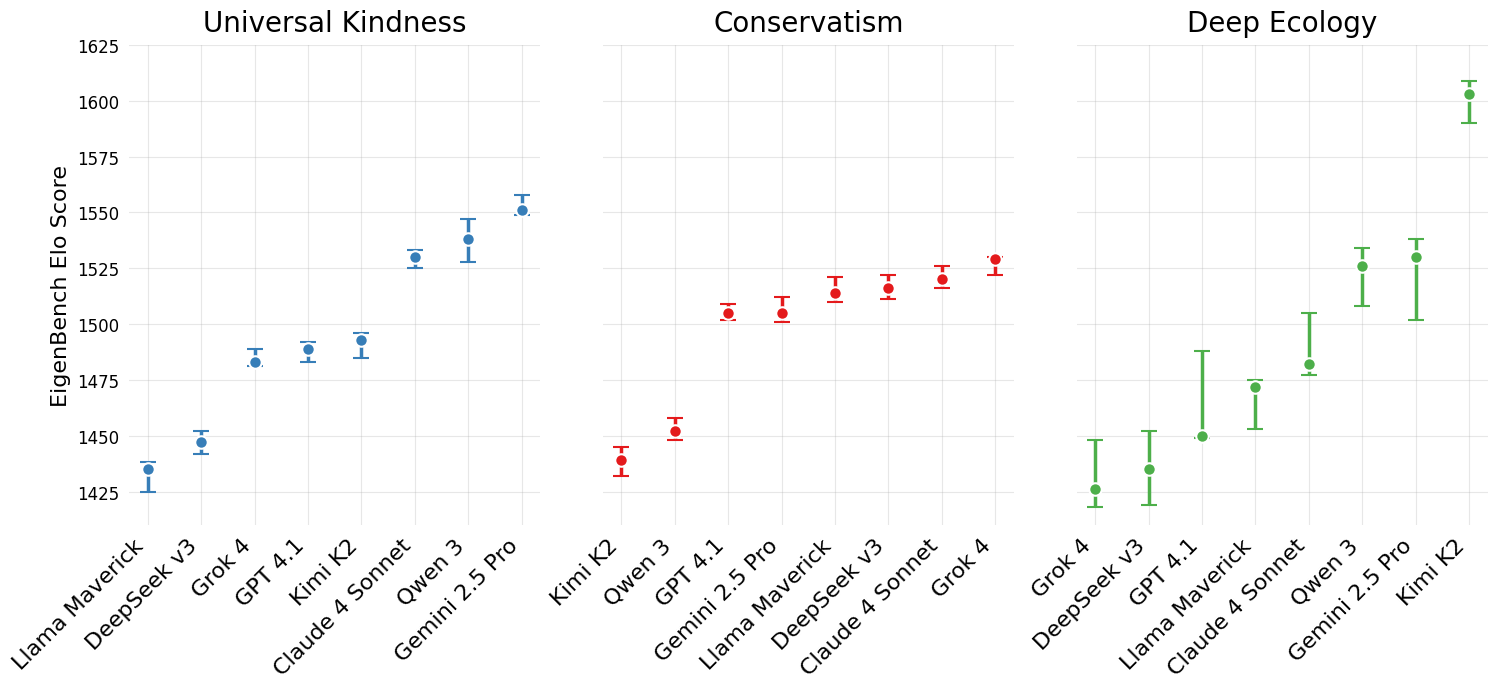

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# First dataset (top plot)
true_means_1 = [1529.65771512, 1489.21640136, 1550.80717926, 1483.19959932, 1446.71638565, 1538.11669974, 1492.72892795, 1434.59616985]

lowerbound_1 = [1525.02869064, 1483.1862129 , 1548.82837066, 1481.35247529, 1442.35668008, 1528.40971266, 1484.95182126, 1424.95877613]
upperbound_1 = [1533.321668  , 1491.69058941, 1558.06226713, 1488.95487088, 1451.61509905, 1546.58943889, 1495.79587001, 1438.05644741]

lowerbound_1 = [round(i) for i in lowerbound_1]
upperbound_1 = [round(i) for i in upperbound_1]
true_means_1 = [round(i) for i in true_means_1]

labels_1 = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3", "Qwen 3", "Kimi K2", "Llama Maverick"]

# Second dataset
true_means_2 = [1482.48474484, 1449.9492038 , 1530.17775485, 1425.5031294 , 1434.85063298, 1526.39856477, 1602.51198593, 1471.70317414]

lowerbound_2 = [1476.84119009, 1448.76250916, 1501.52396231, 1418.34218908, 1418.58837577, 1507.77593116, 1589.57176878, 1452.95697799]
upperbound_2 = [1504.93915959, 1488.38608424, 1537.53426449, 1447.70366122, 1452.18029848, 1534.32140424, 1608.96306149, 1475.16807562]

lowerbound_2 = [round(i) for i in lowerbound_2]
upperbound_2 = [round(i) for i in upperbound_2]
true_means_2 = [round(i) for i in true_means_2]

labels_2 = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3", "Qwen 3", "Kimi K2", "Llama Maverick"]

# Third dataset
true_means_3 = [1519.93520025, 1505.20234001, 1505.06741356, 1528.63498821, 1515.67043375, 1452.14247977, 1438.63380116, 1513.88346054]

lowerbound_3 = [1515.67102027, 1501.82875224, 1501.19318947, 1522.0838857 , 1510.93691368, 1447.57327189, 1431.85725385, 1509.74105112]
upperbound_3 = [1526.19941932, 1509.38620598, 1511.85524852, 1529.83636852, 1522.05212145, 1457.84320898, 1445.46376786, 1520.84253838]

lowerbound_3 = [round(i) for i in lowerbound_3]
upperbound_3 = [round(i) for i in upperbound_3]
true_means_3 = [round(i) for i in true_means_3]

labels_3 = ["Claude 4 Sonnet", "GPT 4.1", "Gemini 2.5 Pro", "Grok 4", "DeepSeek v3", "Qwen 3", "Kimi K2", "Llama Maverick"]

def plot_elo_data(ax, true_means_sorted, lower_errors, upper_errors, labels_sorted, color, title, show_ylabel=True):
    """Plot elo data on given axis, vertical orientation"""
    x_pos = np.arange(len(true_means_sorted))
    
    # Create vertical error bars
    (_, caps, bars) = ax.errorbar(x_pos, true_means_sorted, 
                yerr=[lower_errors, upper_errors],
                fmt='o',
                color=color,
                capsize=6,
                capthick=0,
                elinewidth = 2.5,
                markersize=9,
                markeredgecolor="#FFFFFF",
                markeredgewidth=1.5)
    
    # Customize the plot
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_sorted, rotation=45, ha='right', fontsize=16)
    if title:
        ax.set_title(title, fontsize=20, pad=10)
    
    # Shared ylabel only once
    if show_ylabel:
        ax.set_ylabel("EigenBench Elo Score", fontsize=16)
    else:
        ax.set_ylabel("")
    
    # Grid + styling
    ax.grid(True, alpha=0.3)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='x', bottom=False)
    ax.tick_params(axis='y', labelsize=12)
    
    xlim = ax.get_xlim()
    # Add value annotations
    # for i, (x, y) in enumerate(zip(x_pos, true_means_sorted)):
    #     ax.annotate(f'{y}', 
    #                 (xlim[1] + 0.2, y), 
    #                 xytext=(0, 5), 
    #                 textcoords='offset points',
    #                 ha='center', 
    #                 va='bottom',
    #                 fontsize=9,
    #                 color=color)
    # for i, (x, y) in enumerate(zip(x_pos, true_means_sorted)):
    #     ax.annotate(f'{y}', 
    #                 (xlim[1] + 0.2, y),  # place just to the right
    #                 ha='left', va='center',
    #                 fontsize=9, color=color)

def process_data(lowerbound, upperbound, true_means, labels):
    """Process and sort data by true means"""
    # Combine data and sort by true means
    data = list(zip(true_means, lowerbound, upperbound, labels))
    data_sorted = sorted(data, key=lambda x: x[0])
    
    # Extract sorted data
    true_means_sorted = [x[0] for x in data_sorted]
    lowerbound_sorted = [x[1] for x in data_sorted]
    upperbound_sorted = [x[2] for x in data_sorted]
    labels_sorted = [x[3] for x in data_sorted]
    
    # Calculate error bars
    lower_errors = []
    upper_errors = []
    
    for i in range(len(true_means_sorted)):
        lower_err = true_means_sorted[i] - lowerbound_sorted[i]
        upper_err = upperbound_sorted[i] - true_means_sorted[i]
        
        lower_errors.append(max(0, lower_err))
        upper_errors.append(max(0, upper_err))
    
    return true_means_sorted, lower_errors, upper_errors, labels_sorted

# Process both datasets
data1 = process_data(lowerbound_1, upperbound_1, true_means_1, labels_1)
data2 = process_data(lowerbound_2, upperbound_2, true_means_2, labels_2)
data3 = process_data(lowerbound_3, upperbound_3, true_means_3, labels_3)

# Global y-axis limits
y_min = 1410
y_max = 1625

# Create figure with horizontal subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,7))

# Plot datasets
plot_elo_data(ax1, *data1, color="#377eb8", 
              title='Universal Kindness', show_ylabel=True)
plot_elo_data(ax3, *data2, color="#4daf4a", 
              title='Deep Ecology', show_ylabel=False)
plot_elo_data(ax2, *data3, color="#e41a1c", 
              title='Conservatism', show_ylabel=False)

# Shared limits
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)
ax3.set_ylim(y_min, y_max)

plt.subplots_adjust(wspace=-.5)  

plt.tight_layout()
plt.savefig('figure.png', dpi=500)
plt.show()
